数据分析和清洗

In [ ]:
import json 

js = json.load(open("data/ner_results_all.json"))
js[0]

In [ ]:
import jsonlines
instructions = list(jsonlines.open("../instruction_datasets/instruction_dataall.jsonl"))

In [2]:
import pandas as pd
df = pd.read_csv("./data/umls_kg_filter.csv")

source
Clinical evaluation                                     16133
Surgical action (qualifier value)                       13861
Diagnostic intent (qualifier value)                     13300
Extension Namespace {1000000} (namespace concept)       10711
Skin of body                                            10118
INFLAMM                                                  8386
Morphologically abnormal structure                       8058
Medication Name                                          7977
Measurement (qualifier value)                            7790
Pathological developmental process (qualifier value)     7753
Name: count, dtype: int64


<Axes: >

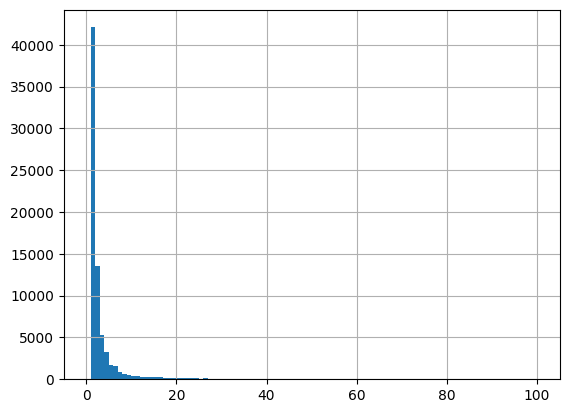

In [3]:
source_counts = df['source'].value_counts()
print(source_counts.head(10))
source_counts.hist(bins=100, range=(0,100))

In [28]:
# filter out rows with source occur more than 5 times
filtered_df = df[df['source'].isin(source_counts[source_counts <= 5].index)]
print(len(filtered_df))

# filter out rows with source equals to target
filtered_df = filtered_df[filtered_df['target']!=filtered_df['source']]
print(len(filtered_df))

filtered_df.to_csv("./data/umls_kg_filter_count_5.csv", index=False)

106503
97039


In [34]:
df['edge'].value_counts()

edge
has finding site                    222618
has associated morphology           126676
has method                          124943
has procedure site                   76044
interprets                           71921
possibly equivalent to               60997
has causative agent                  55257
has active ingredient                51121
has direct procedure site            45664
has pathological process             35034
has dose form                        27215
has intent                           23260
has occurrence                       17473
moved to                             16215
has interpretation                   14603
has direct morphology                12261
has direct substance                 11549
has direct device                    11348
has temporal context                  9815
has subject relationship context      9479
Name: count, dtype: int64

In [ ]:
from tqdm.auto import tqdm
import spacy
nlp = spacy.load("en_core_web_sm")
import random

i = random.choice(instructions)
prompt = i['input'].strip()+" "+i['output'].strip()
doc = nlp(prompt)
from spacy import displacy
displacy.render(doc, style="ent")

In [1]:
import pickle
from transformers import AutoTokenizer
pkl_name = "ep_0"
input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, prompts_list = pickle.load(open(f'data/EntityDataset_1k/{pkl_name}.pkl','rb'))
tok = AutoTokenizer.from_pretrained('/home/cs/yangyuchen/yushengliao/Medical_LLM/FastChat/checkpoints/medical_llama_13b_chatv1.3/checkpoint-4974/')
dash_token="[DASH]"
tok.add_tokens([dash_token])
len(tok)

32001

In [2]:
import numpy as np
import torch
import pandas as pd


i = 0
input_ids=input_ids_list[i]
attention_mask=attention_mask_list[i]
labels=labels_list[i]
hard_position_type_ids=hard_position_type_ids_list[i]
prompt=prompts_list[i]


tokens = tok.batch_decode(input_ids)
tokens = [t.replace('\n', '\\n') for t in tokens]
tokens = [f"{t}-{int(hard_position_type_ids[i])}-{int(int(labels[i])!=-100)}" for i,t in enumerate(tokens)]
attention_mask = attention_mask.numpy().tolist()
attention_mask = [[int(i) for i in row] for row in attention_mask]

matrix = attention_mask
row_index = tokens
col_index = tokens

max_row_length = max(len(row) for row in row_index)
max_col_length = max(len(col) for col in col_index)

# 打开文件
with open(f'{pkl_name}_{i}.txt', 'w') as f:
    f.write(prompt+ '\n\n')
    f.write('attention_mask:\n0:non-entity tokens，1:entity tokens, 2:triplet tokens, 3:triplet target tokens\n\n')
    # 写入列索引
    f.write(" " * max_row_length + "  " + "  ".join(col.ljust(max_col_length) for col in col_index) + '\n')
    # 写入行索引和每行的值
    for i, row in enumerate(matrix):
        f.write(row_index[i].ljust(max_row_length) + "  " + "  ".join(str(val).ljust(max_col_length) for val in row) + '\n')
        
# 创建DataFrame对象
df = pd.DataFrame(matrix, index=row_index, columns=col_index)

# 将DataFrame写入CSV文件
df.to_csv(f'{pkl_name}_{i}.csv')